In [51]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.pipelines.sd_pipeline import SDPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
dtype = torch.float16

device = torch.device("cuda")
pipe = SDPipeline.from_pretrained(sd_repo, torch_dtype=dtype).to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:02<00:00, 11.24it/s]


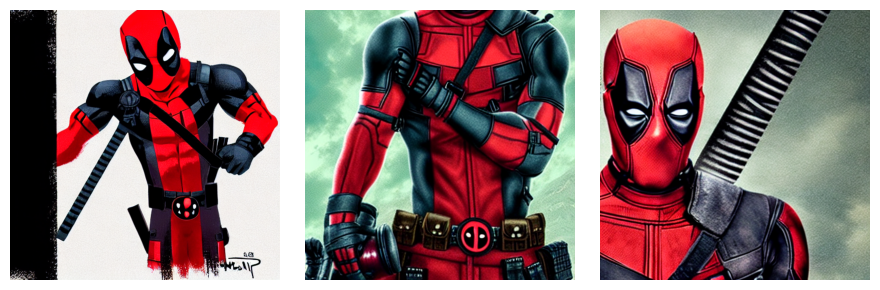

In [48]:
from text3d2video.attn_processor import MyAttnProcessor
from text3d2video.ipython_utils import display_ims

attn_processor = MyAttnProcessor(pipe.unet)
pipe.unet.set_attn_processor(attn_processor)

gen = torch.Generator(device=device)
gen.manual_seed(0)

prompt = "Deadpool"
n_images = 3

images = pipe([prompt] * n_images, generator=gen)
display_ims(images, scale=3)

In [49]:
attn_processor.saved_tensors

keys = list(attn_processor.saved_tensors.keys())
tensors = list(set([k.split(",")[1] for k in keys]))
layers = list(set([k.split(",")[0] for k in keys]))

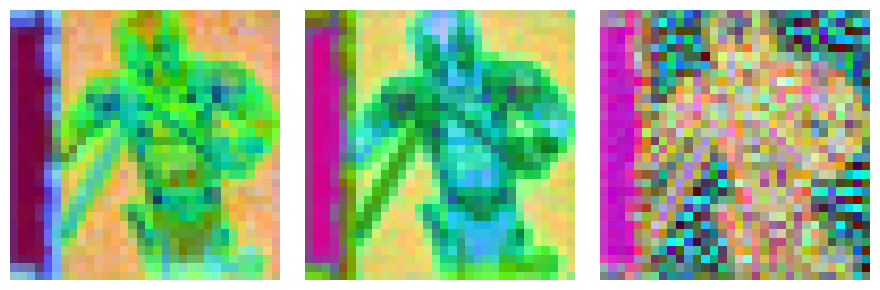

In [50]:
from math import sqrt
from einops import rearrange

from text3d2video.feature_visualization import RgbPcaUtil


layer = layers[0]

query = attn_processor.saved_tensors[f"{layer},query"]
key = attn_processor.saved_tensors[f"{layer},key"]
value = attn_processor.saved_tensors[f"{layer},value"]


def to_square(t):
    return rearrange(t, "(b f) (h w) d -> b f d h w", h=int(sqrt(t.shape[1])), b=2)


query_square = to_square(query)
key_square = to_square(key)
value_square = to_square(value)

frame = 0
batch = 0

query_frame = query_square[batch, frame]
key_frame = key_square[batch, frame]
value_frame = value_square[batch, frame]

pca_query = RgbPcaUtil.init_from_features(
    rearrange(query_frame, "d h w -> (h w) d").cpu()
)
pca_key = RgbPcaUtil.init_from_features(rearrange(key_frame, "d h w -> (h w) d").cpu())
pca_value = RgbPcaUtil.init_from_features(
    rearrange(value_frame, "d h w -> (h w) d").cpu()
)

query_rgb = pca_query.feature_map_to_rgb_pil(query_frame.cpu())
key_rgb = pca_key.feature_map_to_rgb_pil(key_frame.cpu())
value_rgb = pca_value.feature_map_to_rgb_pil(value_frame.cpu())

display_ims([query_rgb, key_rgb, value_rgb], scale=3)